## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from function import Eddies_Tools
import numpy as np

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV





## EDA/Cleaning

In [2]:
trade_chat = pd.read_csv('data\\trade_chat.csv', index_col=0)

In [3]:
trade_chat

,date,time,text,sentiment,target
0,2/22/2022,8:14:35,how long will downtime be,2,Patch
1,2/22/2022,8:14:40,8 hours,2,Patch
2,2/22/2022,8:14:42,few hours,2,Patch
3,2/22/2022,8:14:42,8 hours?,2,Patch
4,2/22/2022,8:14:42,7hrs,2,Patch
...,...,...,...,...,...
1856,2/23/2022,1:15:55,ok cool,3,Patch
1857,2/23/2022,1:16:56,CHANGE NUDES FOR MONTH SUB PLS,2,Chat
1858,2/23/2022,1:17:10,help a gal out,2,Chat
1859,2/23/2022,1:17:19,perhaps,2,Chat


In [4]:
trade_chat['text'].duplicated().value_counts()

False    1387
True      474
Name: text, dtype: int64

In [5]:
trade_chat.drop_duplicates(subset= 'text', inplace=True)
trade_chat.reset_index(drop=True, inplace=True)

In [6]:
trade_chat['text'].duplicated().value_counts()

False    1387
Name: text, dtype: int64

In [7]:
trade_chat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1387 non-null   object
 1   time       1387 non-null   object
 2   text       1387 non-null   object
 3   sentiment  1387 non-null   int64 
 4   target     1387 non-null   object
dtypes: int64(1), object(4)
memory usage: 54.3+ KB


In [8]:
trade_chat.sentiment.value_counts()

2    891
1    438
3     58
Name: sentiment, dtype: int64

In [9]:
trade_chat.target.value_counts()

Chat        677
Patch       482
Trade        78
LFM          65
Boosting     40
Bug          26
LFG          18
bug           1
Name: target, dtype: int64

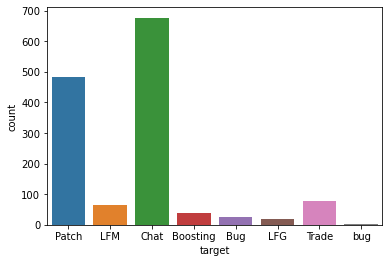

In [10]:
ax=  sns.countplot(x='target', data= trade_chat)

In [11]:
trade_chat[trade_chat.target == 'bug']

,date,time,text,sentiment,target
684,2/22/2022,20:42:05,Arbitor is on break,1,bug


In [12]:
trade_chat.target[684] = 'Bug'

C:\Users\edelp\AppData\Local\Temp/ipykernel_41604/82308061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_chat.target[684] = 'Bug'


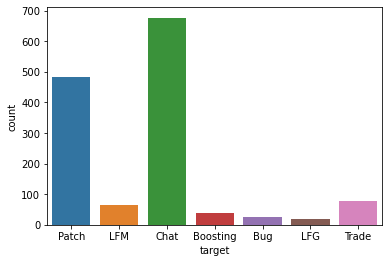

In [13]:
total_target =  sns.countplot(x='target', data= trade_chat)

In [14]:
patch = trade_chat[trade_chat.target == 'Patch']
chat = trade_chat[trade_chat.target == 'Chat']

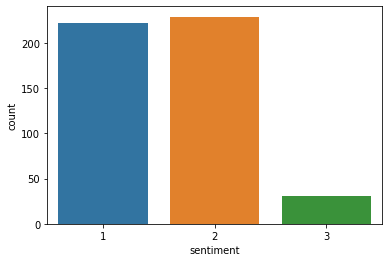

In [15]:
patch_sentiment =  sns.countplot(x='sentiment', data= patch)

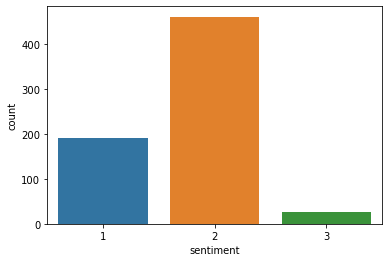

In [16]:
chat_sentiment =  sns.countplot(x='sentiment', data= chat)

In [17]:
patch.sentiment.value_counts()

2    229
1    222
3     31
Name: sentiment, dtype: int64

In [18]:
chat.sentiment.value_counts()

2    461
1    190
3     26
Name: sentiment, dtype: int64

## NLP

In [19]:
et = Eddies_Tools()

In [20]:
s_words = stopwords.words('english')
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
et = Eddies_Tools()

In [21]:
tc_tokenized = et.nlp_tokenizer(trade_chat, tokenizer, s_words)

In [22]:
tc_tokenized

,date,time,text,sentiment,target,text_tokenized,joined_tokens
0,2/22/2022,8:14:35,how long will downtime be,2,Patch,"[long, downtime]",long downtime
1,2/22/2022,8:14:40,8 hours,2,Patch,[hours],hours
2,2/22/2022,8:14:42,few hours,2,Patch,[hours],hours
3,2/22/2022,8:14:42,8 hours?,2,Patch,[hours],hours
4,2/22/2022,8:14:42,7hrs,2,Patch,[7hrs],7hrs
...,...,...,...,...,...,...,...
1382,2/23/2022,1:15:55,ok cool,3,Patch,"[ok, cool]",ok cool
1383,2/23/2022,1:16:56,CHANGE NUDES FOR MONTH SUB PLS,2,Chat,"[CHANGE, NUDES, FOR, MONTH, SUB, PLS]",CHANGE NUDES FOR MONTH SUB PLS
1384,2/23/2022,1:17:10,help a gal out,2,Chat,"[help, gal]",help gal
1385,2/23/2022,1:17:19,perhaps,2,Chat,[perhaps],perhaps


In [23]:
chat_tokenized = tc_tokenized[tc_tokenized.target == 'Chat']
patch_tokenized = tc_tokenized[tc_tokenized.target == 'Patch']

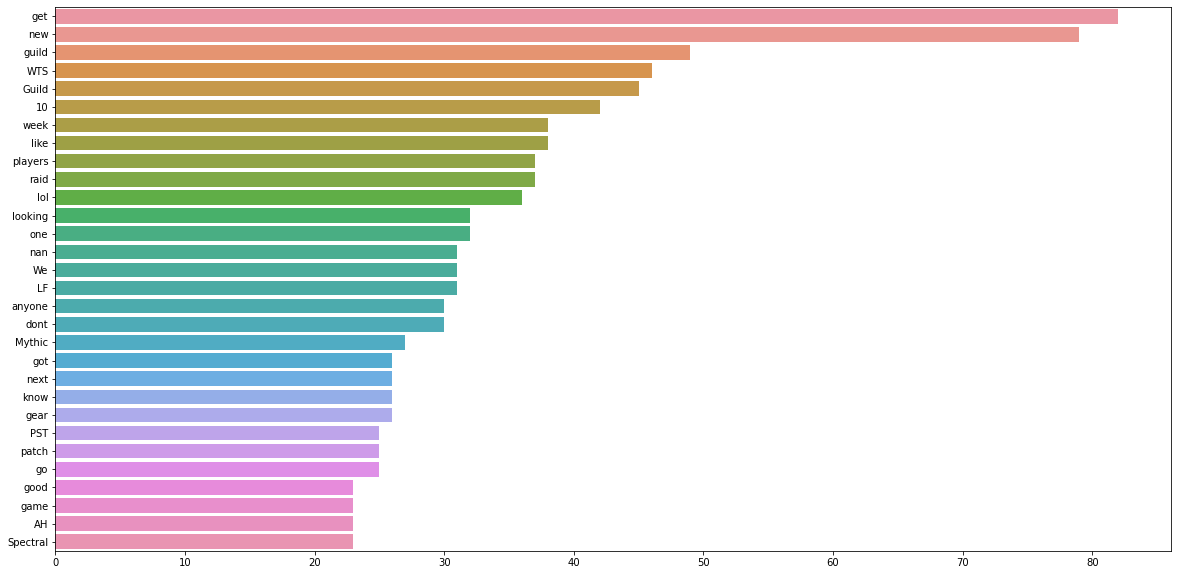

In [24]:
fdist = FreqDist(tc_tokenized.text_tokenized.explode())

top_30_words = list(zip(*fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)


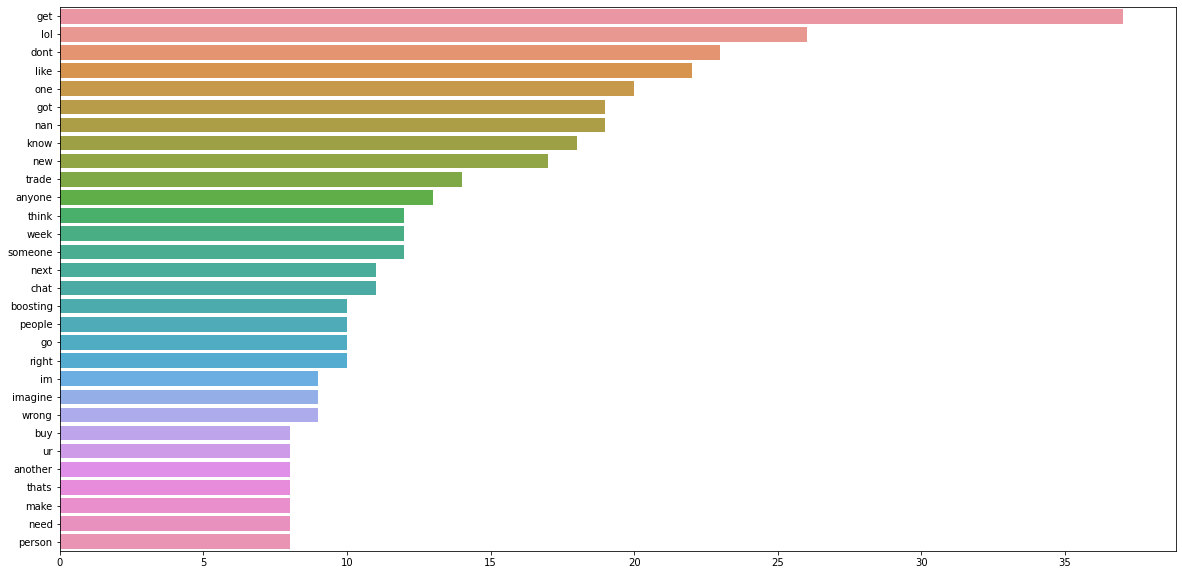

In [25]:
chat_fdist = FreqDist(chat_tokenized.text_tokenized.explode())

top_30_words = list(zip(*chat_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

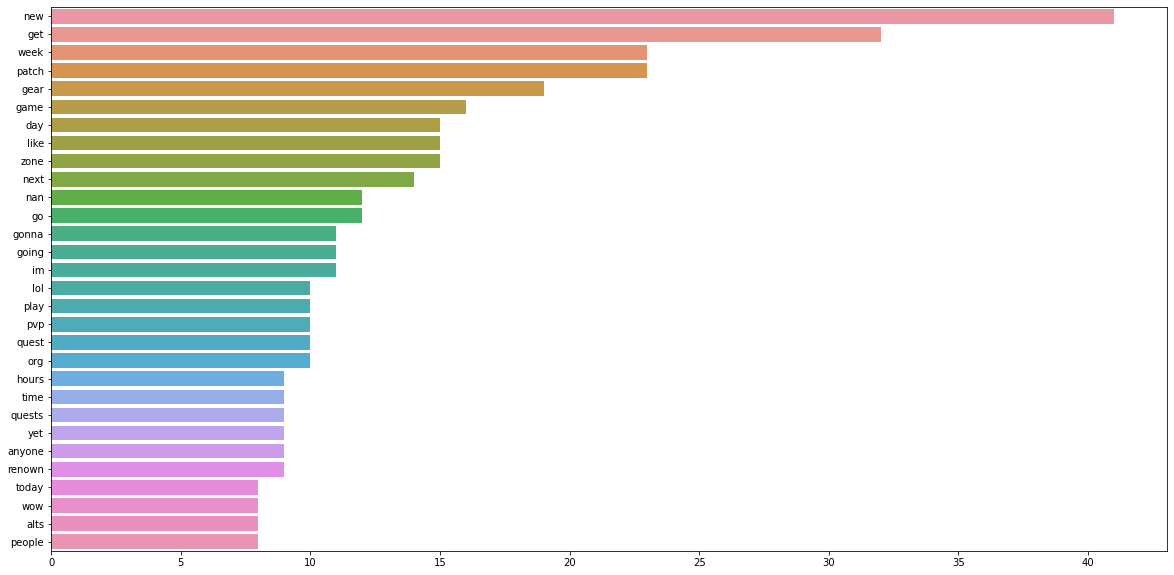

In [26]:
patch_fdist = FreqDist(patch_tokenized.text_tokenized.explode())

top_30_words = list(zip(*patch_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

In [27]:

counter = 0
for lists in patch_tokenized.text_tokenized:
    if lists == []:
        counter += 1
        print('YES')

counter

YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES


12

In [28]:
chat_tokenized.text_tokenized.loc[10:70]

12    [wow, said, main, account, ban, anyone, help, ...
13    [nerd, raging, hard, untethered, rage, knows, ...
14              [Eh, lol, wanna, risk, getting, banned]
15                      [buy, new, one, blizzard, shop]
16                                             [banned]
17                                          [SAM, DEAN]
18                   [got, banned, d2r, deserved, haha]
20                 [many, times, spam, nword, malabrah]
21    [said, selling, runs, cause, play, carry, stre...
22                                    [oh, botted, lol]
23                                  [feel, ban, unjust]
24                                                [lol]
25                                                 [xd]
26                                                 [tt]
27          [yes, yes, unjust, ban, sure, Get, deserve]
28                                                   []
29                       [Ok, got, banned, last, night]
30                           [got, boosted, ur, 

In [29]:
trade_chat.loc[34]

date         2/22/2022
time           8:18:11
text                =x
sentiment            2
target            Chat
Name: 34, dtype: object

In [30]:
neg_patch = patch_tokenized[patch_tokenized.sentiment == 1]
neg_chat = chat_tokenized[chat_tokenized.sentiment == 1]

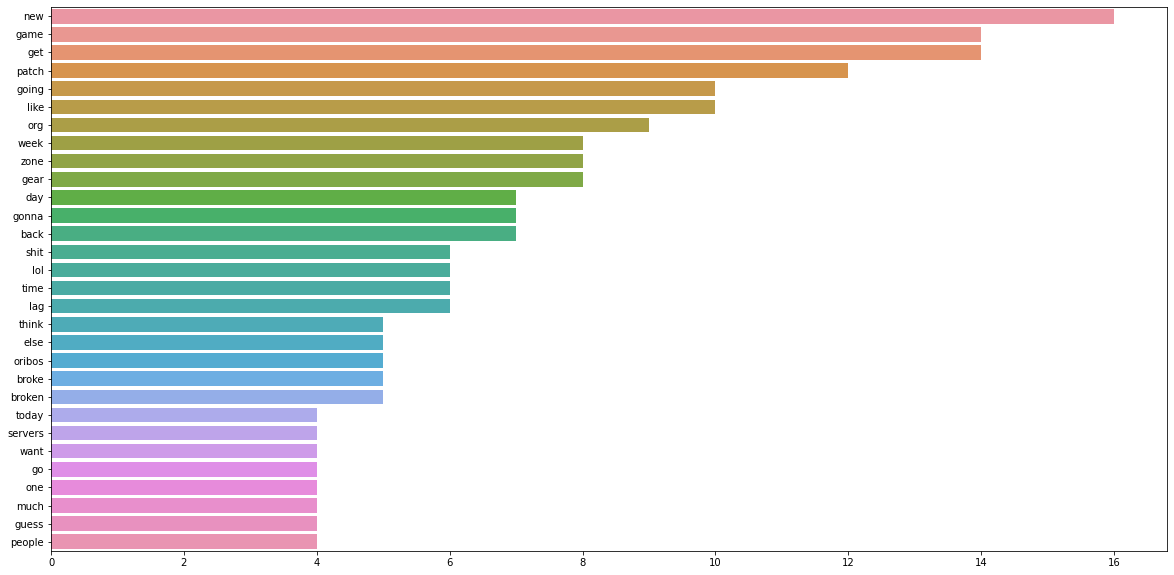

In [31]:
neg_patch_fdist = FreqDist(neg_patch.text_tokenized.explode())

top_30_words = list(zip(*neg_patch_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

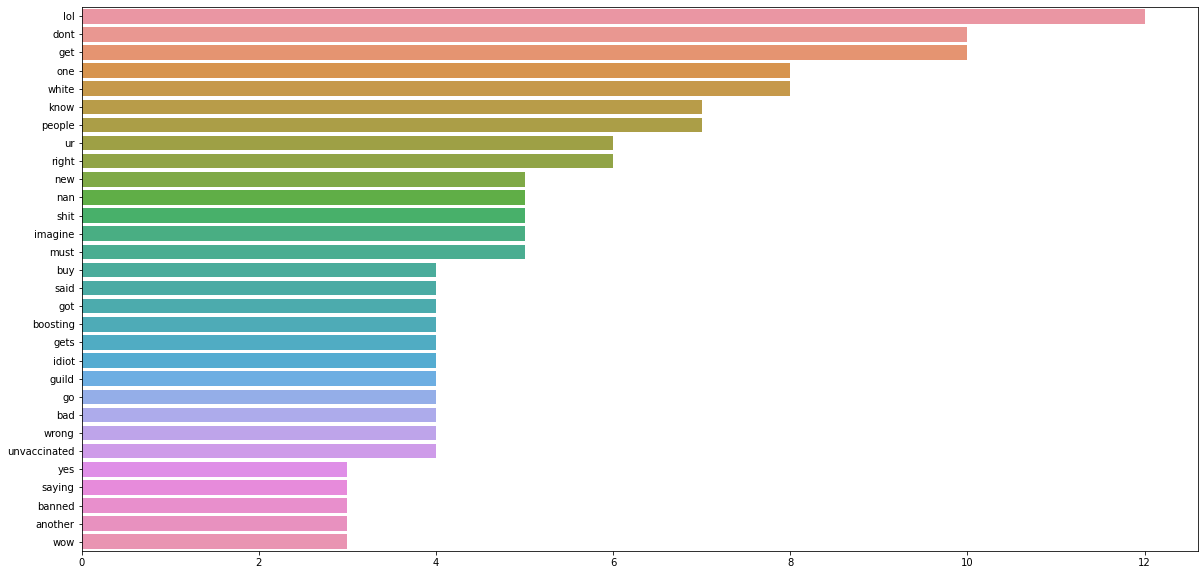

In [32]:
neg_chat_fdist = FreqDist(neg_chat.text_tokenized.explode())

top_30_words = list(zip(*neg_chat_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

## Baseline Models

In [33]:
X = tc_tokenized['joined_tokens']
y_sentiment = tc_tokenized['sentiment']
y_target = tc_tokenized['target']

### Sentiment Models

In [34]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sentiment, test_size= 0.25, random_state=5)

In [35]:
y_test_s.value_counts()

2    224
1    108
3     15
Name: sentiment, dtype: int64

In [36]:
s_labels = ['neg', 'neutral', 'pos']

In [37]:
sentiment_models = {}

#### Stochastic Gradient Descent Model

In [38]:
sgd_sentiment = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, sgd_sentiment = et.run_model(X, y_sentiment, sgd_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.6808
Accuracy: 0.6715


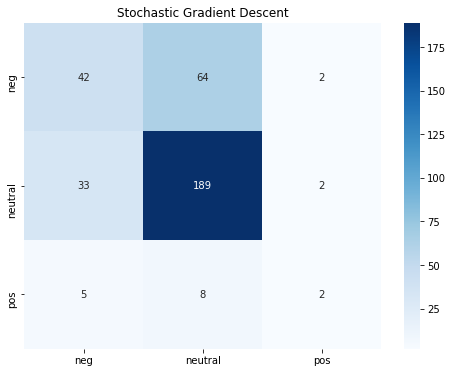

In [39]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Stochastic Gradient Descent');

#### Random Forest Model

In [40]:
rfc_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, rfc_sentiment = et.run_model(X, y_sentiment, rfc_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.7048
Accuracy: 0.6657


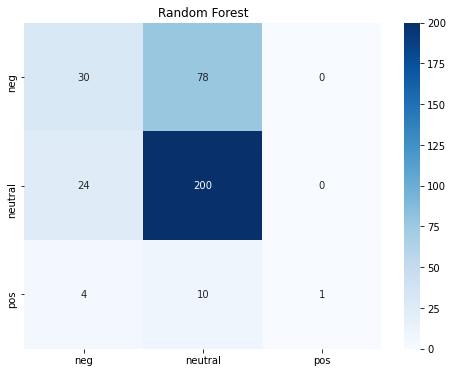

In [41]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Random Forest');

#### Naive Bayes Model

In [42]:
naive_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, naive_sentiment = et.run_model(X, y_sentiment, naive_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.6894
Accuracy: 0.6888


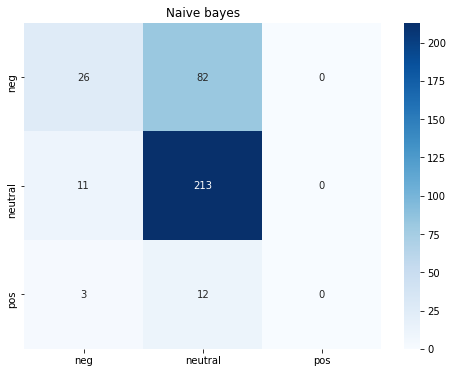

In [43]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Naive bayes');

#### Logistic Regression Model

In [44]:
lg_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

cv_mean, accuracy, y_pred, lg_sentiment = et.run_model(X, y_sentiment, lg_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.701
Accuracy: 0.6859


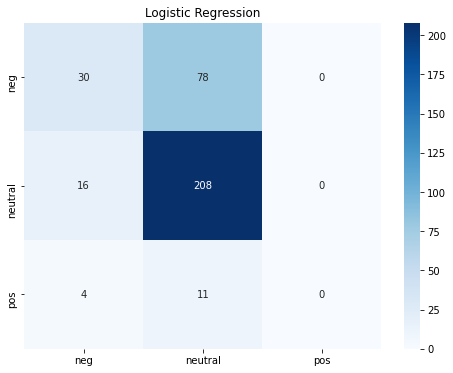

In [45]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Logistic Regression');

In [46]:
sentiment_models

{'SGD': {'CV Mean': 0.6808, 'Accuracy': 0.6715},
 'RFC': {'CV Mean': 0.7048, 'Accuracy': 0.6657},
 'Naive': {'CV Mean': 0.6894, 'Accuracy': 0.6888},
 'LogReg': {'CV Mean': 0.701, 'Accuracy': 0.6859}}

### Target Models

In [47]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_target, test_size= 0.25, random_state=5)

In [48]:
target_models = {}

In [49]:
y_test_t.value_counts()

Chat        175
Patch       113
Trade        18
LFM          15
Boosting     12
Bug           8
LFG           6
Name: target, dtype: int64

In [50]:
t_labels = sorted(list(tc_tokenized.target.value_counts().index))

#### Stochastic Gradient Descent Model

In [51]:
sgd_target = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, sgd_target = et.run_model(X, y_target, sgd_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}



CV Mean: 0.6769
Accuracy: 0.6369


Text(0.5, 1.0, 'Stochastic Gradient Descent')

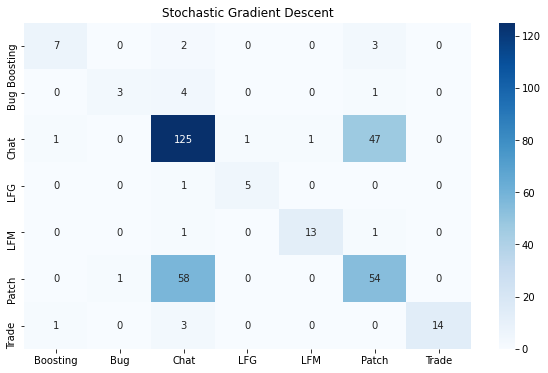

In [52]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Stochastic Gradient Descent')

#### Random Forest Model

In [53]:
rfc_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, rfc_target = et.run_model(X, y_target, rfc_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.675
Accuracy: 0.634


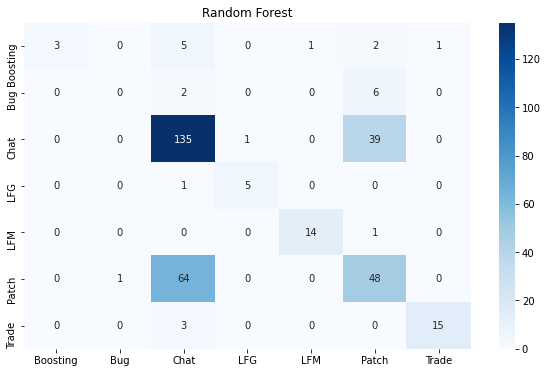

In [54]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Random Forest');

#### Naive Bayes Model

In [55]:
naive_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, naive_target = et.run_model(X, y_target, naive_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.6394
Accuracy: 0.6167


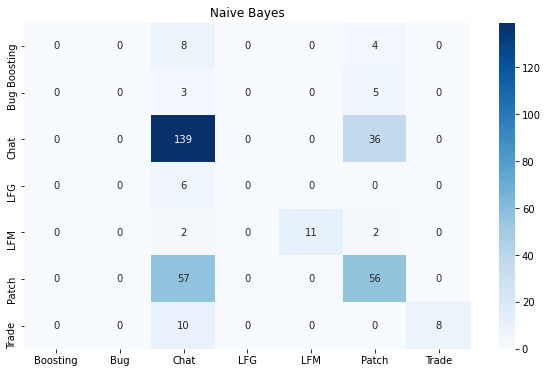

In [56]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Naive Bayes');

#### Logistic Regression Model

In [57]:
lg_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

cv_mean, accuracy, y_pred, lg_target = et.run_model(X, y_target, lg_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.6519
Accuracy: 0.6311


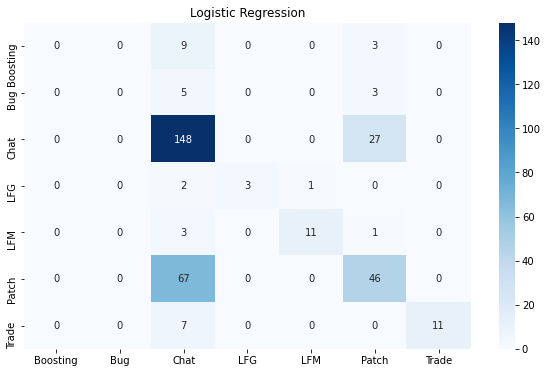

In [58]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Logistic Regression');

In [59]:
target_models

{'SGD': {'CV Mean': 0.6769, 'Accuracy': 0.6369},
 'RFC': {'CV Mean': 0.675, 'Accuracy': 0.634},
 'Naive': {'CV Mean': 0.6394, 'Accuracy': 0.6167},
 'LogReg': {'CV Mean': 0.6519, 'Accuracy': 0.6311}}

### Base Model Performance

In [60]:
s_model_df = pd.DataFrame()
s_bmp_labels = list(sentiment_models.keys())

In [61]:
model_list = []
cv_list = []
acc_list = []

for model_name in s_bmp_labels:
    cv_list.append(list(sentiment_models[model_name].values())[0])
    acc_list.append(list(sentiment_models[model_name].values())[1])

s_model_df['model'] = sentiment_models.keys()
s_model_df['cv_mean'] = cv_list
s_model_df['accuracy'] = acc_list

s_model_df


,model,cv_mean,accuracy
0,SGD,0.6808,0.6715
1,RFC,0.7048,0.6657
2,Naive,0.6894,0.6888
3,LogReg,0.7010,0.6859


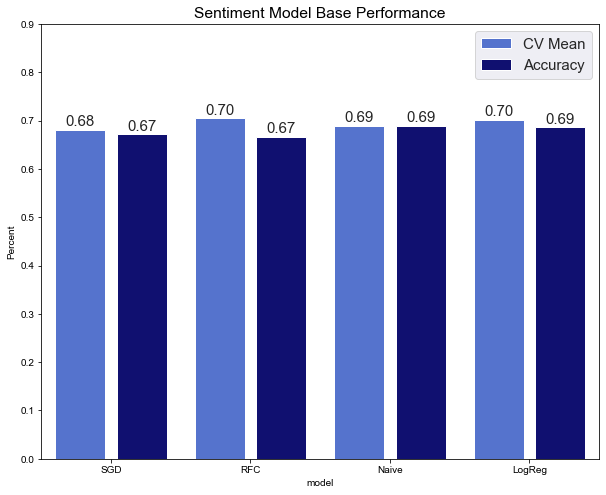

In [62]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=s_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=s_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= .9)
ax.legend(fontsize= 15)
ax.set_title('Sentiment Model Base Performance')


plt.show()

In [63]:
t_model_df = pd.DataFrame()
t_bmp_labels = list(target_models.keys())

In [64]:
model_list = []
cv_list = []
acc_list = []

for model_name in t_bmp_labels:
    cv_list.append(list(target_models[model_name].values())[0])
    acc_list.append(list(target_models[model_name].values())[1])

t_model_df['model'] = target_models.keys()
t_model_df['cv_mean'] = cv_list
t_model_df['accuracy'] = acc_list

t_model_df

,model,cv_mean,accuracy
0,SGD,0.6769,0.6369
1,RFC,0.6750,0.6340
2,Naive,0.6394,0.6167
3,LogReg,0.6519,0.6311


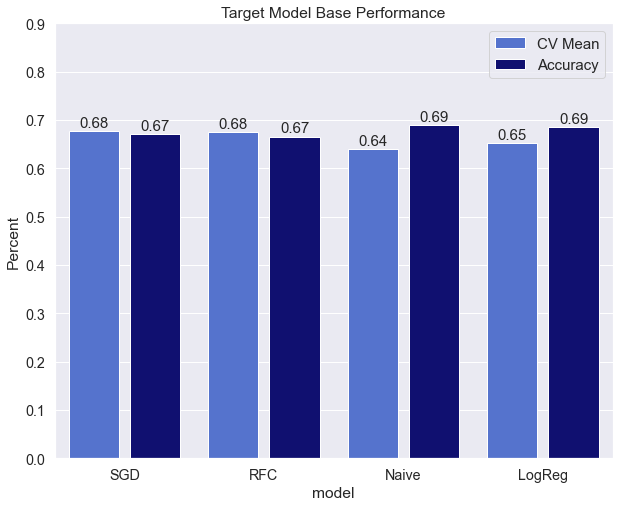

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=t_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=s_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= .9)
ax.legend(fontsize= 15)
ax.set_title('Target Model Base Performance')


plt.show()

## Tuned Models

### Sentiment Models

In [67]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sentiment, test_size= 0.25, random_state=5)

In [66]:
sentiment_models_t = {}

#### Stochastic Gradient Descent Model

In [68]:
# sgd_sentiment = Pipeline([('vect', CountVectorizer()), 
#                ('tfidf', TfidfTransformer()),
#                ('sgd', SGDClassifier(random_state=5)),
#               ])

# sgd_sentiment.fit(X_train_s, y_train_s)

# sgd_params = {
#     'vect__strip_accents':[None,'ascii','unicode'],
#     'vect__lowercase': [True, False],
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'tfidf__smooth_idf': [True, False],
#     'sgd__loss': ['hinge','log','modified_huber','squared_hinge'],
#     'sgd__max_iter':[1000,2000],
#     'sgd__class_weight': [None, 'balanced']
# }

# sgd_gs = GridSearchCV(sgd_sentiment,param_grid=sgd_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

# sgd_gs = sgd_gs.fit(X_train_s, y_train_s)

In [69]:
# sgd_gs.best_score_

In [70]:
# sgd_gs.best_params_

In [71]:
sgd_sentiment = Pipeline([('vect', CountVectorizer(ngram_range= (1,2))), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss = 'log', random_state=5)),
              ])

cv_mean, accuracy, y_pred, sgd_sentiment = et.run_model(X, y_sentiment, sgd_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.7135
Accuracy: 0.6888


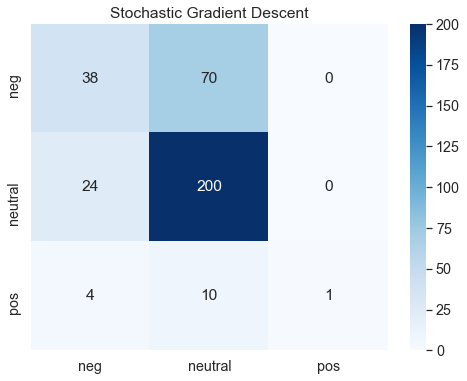

In [72]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Stochastic Gradient Descent');

#### Random Forest Model

In [73]:
# rfc_sentiment = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('rfc', RandomForestClassifier(random_state=5)),
#               ])

# rfc_sentiment.fit(X_train_s, y_train_s)

# rfc_params = {
#     'vect__strip_accents':[None,'ascii','unicode'],
#     'vect__lowercase': [True, False],
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'tfidf__smooth_idf': [True, False],
#     'rfc__n_estimators': [100,200,300,400,500],
#     'rfc__criterion': ['gini','entropy'],
#     'rfc__max_depth': [1,3,5],
#     'rfc__class_weight': [None,'balanced', 'balanced_subsample']
# }

# rfc_gs = GridSearchCV(rfc_sentiment, param_grid= rfc_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

# rfc_gs = rfc_gs.fit(X_train_s, y_train_s)

In [74]:
# rfc_gs.best_score_ 

In [75]:
# rfc_gs.best_params_

In [76]:
rfc_sentiment = Pipeline([('vect', CountVectorizer(strip_accents='ascii',ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(class_weight= 'balanced_subsample',
                                              criterion= 'gini', 
                                              max_depth=3,
                                              n_estimators = 400,
                                              random_state=5))
              ])

cv_mean, accuracy, y_pred, rfc_sentiment = et.run_model(X, y_sentiment, rfc_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.6587
Accuracy: 0.6686


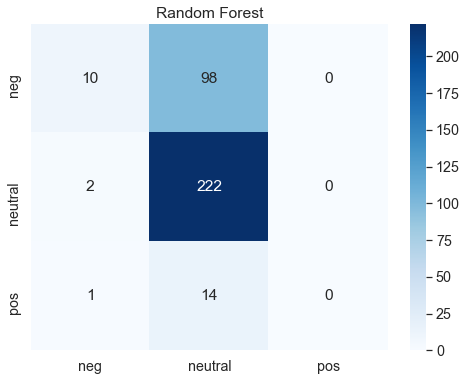

In [77]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Random Forest');

#### Naive Bayes Model

In [78]:
# naive_sentiment = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('naive', MultinomialNB()),
#               ])

# naive_sentiment.fit(X_train_s, y_train_s)

# naive_params = {
#     'vect__strip_accents':[None,'ascii','unicode'],
#     'vect__lowercase': [True, False],
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'tfidf__smooth_idf': [True, False]

# }

# naive_gs = GridSearchCV(naive_sentiment, param_grid= naive_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

# naive_gs = naive_gs.fit(X_train_s, y_train_s)

In [79]:
# naive_gs.best_score_ 

In [80]:
# naive_gs.best_params_

In [81]:
naive_sentiment = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, naive_sentiment = et.run_model(X, y_sentiment, naive_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.6923
Accuracy: 0.6888


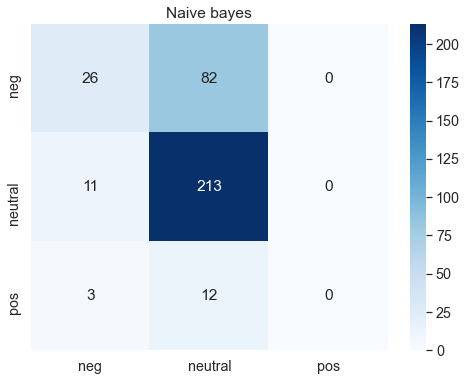

In [82]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Naive bayes');

#### Logistic Regression Model

In [83]:
# lg_sentiment = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('lg', LogisticRegression(random_state=5)),
#               ])

# lg_sentiment.fit(X_train_s, y_train_s)

# lg_params = {
#     'vect__strip_accents':[None,'ascii','unicode'],
#     'vect__lowercase': [True, False],
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'tfidf__smooth_idf': [True, False],
#     'lg__C': [1,5,10],
#     'lg__solver': ['liblinear','lbfgs', 'sag', 'saga','newton-cg'],
#     'lg__class_weight': ['balanced', None],
#     'lg__multi_class': ['auto', 'ovr', 'multinomial'],
#     'lg__penalty':['l1','l2','elasticnet', 'none']
    

# }

# lg_gs = GridSearchCV(lg_sentiment, param_grid= lg_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

# lg_gs = lg_gs.fit(X_train_s, y_train_s)

In [84]:
# lg_gs.best_score_ 

In [85]:
# lg_gs.best_params_

In [86]:
lg_sentiment = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', LogisticRegression(C= 10, class_weight= None, multi_class= 'auto', penalty= 'l2', solver= 'liblinear', random_state=5)),
              ])

cv_mean, accuracy, y_pred, lg_sentiment = et.run_model(X, y_sentiment, lg_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.7202
Accuracy: 0.6859


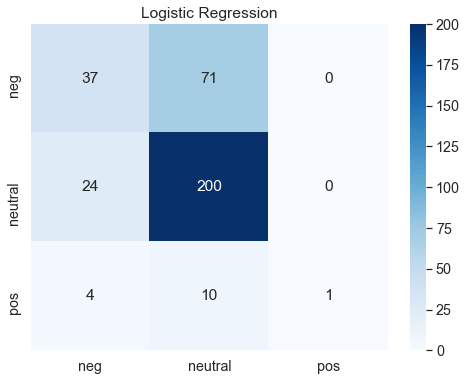

In [87]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Logistic Regression');

In [88]:
sentiment_models_t

{'SGD': {'CV Mean': 0.7135, 'Accuracy': 0.6888},
 'RFC': {'CV Mean': 0.6587, 'Accuracy': 0.6686},
 'Naive': {'CV Mean': 0.6923, 'Accuracy': 0.6888},
 'LogReg': {'CV Mean': 0.7202, 'Accuracy': 0.6859}}

### Target Models

In [89]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_target, test_size= 0.25, random_state=5)

In [90]:
target_models_t = {}

#### Stochastic Gradient Descent Model

In [91]:
# sgd_target = Pipeline([('vect', CountVectorizer()), 
#                ('tfidf', TfidfTransformer()),
#                ('sgd', SGDClassifier(random_state=5)),
#               ])

# sgd_target.fit(X_train_t, y_train_t)

# sgd_params = {
#     'vect__strip_accents':[None,'ascii','unicode'],
#     'vect__lowercase': [True, False],
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'tfidf__smooth_idf': [True, False],
#     'sgd__loss': ['hinge','log','modified_huber','squared_hinge'],
#     'sgd__max_iter':[1000,2000],
#     'sgd__class_weight': [None, 'balanced']
# }

# sgd_gs = GridSearchCV(sgd_target,param_grid=sgd_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

# sgd_gs = sgd_gs.fit(X_train_t, y_train_t)

In [92]:
# sgd_gs.best_score_

In [93]:
# sgd_gs.best_params_

In [94]:
sgd_target = Pipeline([('vect', CountVectorizer(ngram_range= (1,2))), 
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier(loss = 'log', random_state=5)),
              ])

cv_mean, accuracy, y_pred, sgd_target = et.run_model(X, y_target, sgd_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models_t['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.7
Accuracy: 0.6599


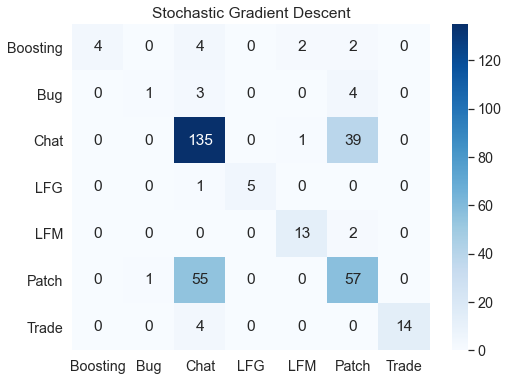

In [95]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Stochastic Gradient Descent');

#### Random Forest Model

In [96]:
# rfc_target = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('rfc', RandomForestClassifier(random_state=5)),
#               ])

# rfc_target.fit(X_train_t, y_train_t)

# rfc_params = {
#     'vect__strip_accents':[None,'ascii','unicode'],
#     'vect__lowercase': [True, False],
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'tfidf__smooth_idf': [True, False],
#     'rfc__n_estimators': [100,200,300,400,500],
#     'rfc__criterion': ['gini','entropy'],
#     'rfc__max_depth': [1,3,5],
#     'rfc__class_weight': [None,'balanced', 'balanced_subsample']
# }

# rfc_gs = GridSearchCV(rfc_target, param_grid= rfc_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

# rfc_gs = rfc_gs.fit(X_train_t, y_train_t)

In [97]:
# rfc_gs.best_score_ 

In [98]:
# rfc_gs.best_params_

In [99]:
rfc_target = Pipeline([('vect', CountVectorizer(strip_accents='ascii',ngram_range=(1,1))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(class_weight= 'balanced_subsample',
                                              criterion= 'entropy', 
                                              max_depth=5,
                                              n_estimators = 500,
                                              random_state=5))
              ])

cv_mean, accuracy, y_pred, rfc_target = et.run_model(X, y_target, rfc_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models_t['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.626
Accuracy: 0.6167


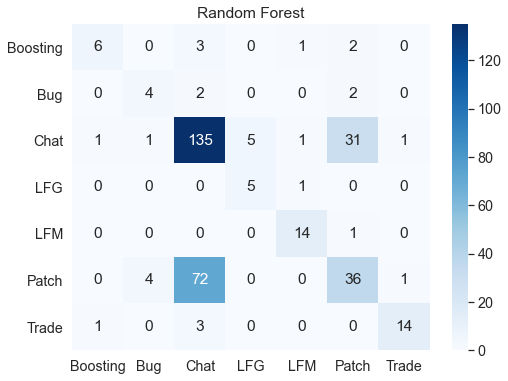

In [100]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Random Forest');

#### Naive Bayes Model

In [101]:
# naive_target = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('naive', MultinomialNB()),
#               ])

# naive_target.fit(X_train_t, y_train_t)

# naive_params = {
#     'vect__strip_accents':[None,'ascii','unicode'],
#     'vect__lowercase': [True, False],
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'tfidf__smooth_idf': [True, False]

# }

# naive_gs = GridSearchCV(naive_target, param_grid= naive_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

# naive_gs = naive_gs.fit(X_train_t, y_train_t)

In [102]:
# naive_gs.best_score_ 

In [103]:
# naive_gs.best_params_

In [104]:
naive_target = Pipeline([('vect', CountVectorizer(lowercase=True, strip_accents=None, ngram_range=(1,1))),
               ('tfidf', TfidfTransformer(smooth_idf=True)),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, naive_target = et.run_model(X, y_target, naive_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models_t['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.6394
Accuracy: 0.6167


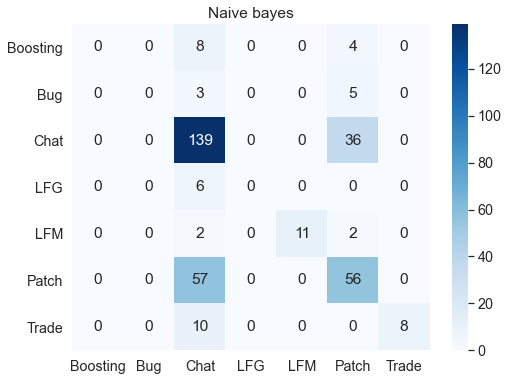

In [105]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Naive bayes');

#### Logistic Regression Model

In [106]:
# lg_target = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('lg', LogisticRegression(random_state=5)),
#               ])

# lg_target.fit(X_train_t, y_train_t)

# lg_params = {
#     'vect__strip_accents':[None,'ascii','unicode'],
#     'vect__lowercase': [True, False],
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'tfidf__smooth_idf': [True, False],
#     'lg__C': [1,5,10],
#     'lg__solver': ['liblinear','lbfgs', 'sag', 'saga','newton-cg'],
#     'lg__class_weight': ['balanced', None],
#     'lg__multi_class': ['auto', 'ovr', 'multinomial'],
#     'lg__penalty':['l1','l2','elasticnet', 'none'],
#     'lg__max_iter': [100, 200, 300]
    

# }

# lg_gs = GridSearchCV(lg_target, param_grid= lg_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

# lg_gs = lg_gs.fit(X_train_t, y_train_t)

In [107]:
# lg_gs.best_score_ 

In [108]:
# lg_gs.best_params_

In [109]:
lg_target = Pipeline([('vect', CountVectorizer(lowercase=True, ngram_range=(1,1))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', LogisticRegression(C= 5, max_iter=10000, class_weight= 'balanced', multi_class= 'auto', penalty= 'l2', solver= 'sag', random_state=5)),
              ])

cv_mean, accuracy, y_pred, lg_target = et.run_model(X, y_target, lg_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models_t['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


CV Mean: 0.7019
Accuracy: 0.6628


C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


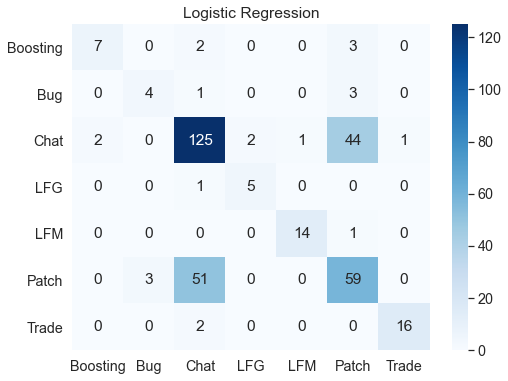

In [110]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Logistic Regression');

In [117]:
target_models_t

{'SGD': {'CV Mean': 0.7, 'Accuracy': 0.6599},
 'RFC': {'CV Mean': 0.626, 'Accuracy': 0.6167},
 'Naive': {'CV Mean': 0.6394, 'Accuracy': 0.6167},
 'LogReg': {'CV Mean': 0.7019, 'Accuracy': 0.6628}}

### Tuned Model Performance

In [111]:
s_t_model_df = pd.DataFrame()
s_tmp_labels = list(sentiment_models_t.keys())

In [112]:
model_list = []
cv_list = []
acc_list = []

for model_name in s_tmp_labels:
    cv_list.append(list(sentiment_models_t[model_name].values())[0])
    acc_list.append(list(sentiment_models_t[model_name].values())[1])

s_t_model_df['model'] = sentiment_models_t.keys()
s_t_model_df['cv_mean'] = cv_list
s_t_model_df['accuracy'] = acc_list

s_t_model_df

,model,cv_mean,accuracy
0,SGD,0.7135,0.6888
1,RFC,0.6587,0.6686
2,Naive,0.6923,0.6888
3,LogReg,0.7202,0.6859


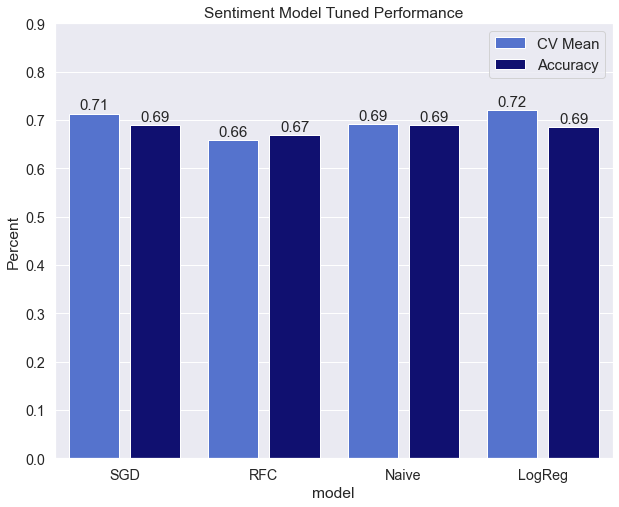

In [113]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=s_t_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=s_t_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= .9)
ax.legend(fontsize= 15)
ax.set_title('Sentiment Model Tuned Performance')


plt.show()

In [114]:
t_t_model_df = pd.DataFrame()
t_tmp_labels = list(target_models_t.keys())

In [115]:
model_list = []
cv_list = []
acc_list = []

for model_name in t_tmp_labels:
    cv_list.append(list(target_models_t[model_name].values())[0])
    acc_list.append(list(target_models_t[model_name].values())[1])

t_t_model_df['model'] = target_models_t.keys()
t_t_model_df['cv_mean'] = cv_list
t_t_model_df['accuracy'] = acc_list

t_t_model_df

,model,cv_mean,accuracy
0,SGD,0.7000,0.6599
1,RFC,0.6260,0.6167
2,Naive,0.6394,0.6167
3,LogReg,0.7019,0.6628


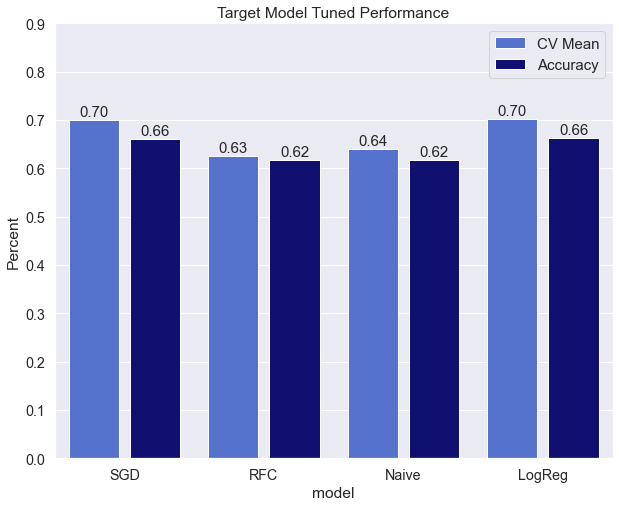

In [116]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=t_t_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=t_t_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= .9)
ax.legend(fontsize= 15)
ax.set_title('Target Model Tuned Performance')


plt.show()